<a href="https://colab.research.google.com/github/ianjamesbarnett/2022NFLBigDataBowl/blob/main/calcCOYOTEv2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import io
import torchvision as tv 
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pickle
import gc


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_dir = "/content/drive/MyDrive/NFLBigDataBowl2022"
os.chdir(data_dir)

#YEAR="2018";maxplays=756
#YEAR="2019";maxplays=749
YEAR="2020";maxplays=855


filein=open(data_dir+"/tracking"+YEAR+".csv",'r')
line=filein.readline()

filein2=open(data_dir+"/games.csv",'r')
filein2.readline()
game_d={}
for line in filein2:
    line_v=[x.strip('\"') for x in line.strip("\n").split(",")]
    game_d[line_v[0]]=line_v[1:]

filein3=open(data_dir+"/plays.csv",'r')
filein3.readline()
play_d={}
for line in filein3:
    line_v=[x.strip('\"') for x in line.strip("\n").split(",")]
    play_d[line_v[0]+"-"+line_v[1]]=line_v[2:]

In [ ]:
filein4=open(data_dir+"/players.csv",'r') #nflID, height, weight, birthdate, college, position, displayname, 
filein4.readline()
players_info_d={}
for line in filein4:
    line_v=[x.strip('\"') for x in line.strip("\n").split(",")]
    players_info_d[line_v[0]]=line_v[1:]
filein4.close()

['6-6', '263', '1982-05-06', 'Tennessee', 'TE', 'Jason Witten']

In [ ]:
# get IDs of all plays to turn into videos (returned punts and kicks)
catchframe = {}
pID_s=set()
filein.seek(0)
for line in filein:
    line_v=line.split(",")
    if line_v[8].strip("\"")=="punt_received" or line_v[8].strip("\"")=="kick_received":
        gpID = line_v[15]+"-"+line_v[16]
        if play_d[gpID][6]=="Return":
            pID_s.add(gpID)
            catchframe[gpID]=line_v[14]

#x,y,s,a,dis,o,dir,jersey,pos,team,playdirectino
ret_vids = pickle.load(open("retvids1_final_"+YEAR+".pickle",'rb'))# 3 layers of dictionaries: playID, frameID, playerID
ret_vids2=pickle.load(open("retvids2_final_"+YEAR+".pickle",'rb'))
pIDs=list(ret_vids.keys())

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(154, 200)
        self.fc2 = nn.Linear(200,100)
        self.fc3 = nn.Linear(100,20)
        self.fc4 = nn.Linear(20, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)#.squeeze()
        return x
    
    

net = Net()
modelpath=data_dir+"/retyardFFNN_16.pt"
net.load_state_dict(torch.load(modelpath))

<All keys matched successfully>

In [ ]:
def PlotFieldPosition(temp):
    plotdata = {'x':[],'y':[],'s':[],'a':[],'o':[],'dir':[],'jerseyNumber':[],'position':[],'team':[],'color':[]}
    for key in temp:
        plotdata['x'].append(float(temp[key][0]))
        plotdata['y'].append(float(temp[key][1]))
        plotdata['s'].append(float(temp[key][2]))
        plotdata['a'].append(float(temp[key][3]))
        plotdata['o'].append(temp[key][5])
        plotdata['dir'].append(temp[key][6])
        plotdata['jerseyNumber'].append(temp[key][7])
        plotdata['position'].append(temp[key][8])
        plotdata['team'].append(temp[key][9])
        if temp[key][9].strip("\"")=="football":
            plotdata['color'].append(0)    
        elif temp[key][9].strip("\"")=="away":
            plotdata['color'].append(1)    
        else:
            plotdata['color'].append(2)    
    plt.scatter('y','x',c='color',data=plotdata)
    plt.show()

def os2xyspeed(o,s):
  if o<90:
    ot=o*2*np.pi/360
    x=s*np.sin(ot)
    y=s*np.cos(ot)
  elif o<180:
    ot=(180-o)*2*np.pi/360
    x=s*np.sin(ot)
    y=-s*np.cos(ot)
  elif o<180:
    ot=(o-180)*2*np.pi/360
    x=-s*np.sin(ot)
    y=-s*np.cos(ot)
  else:
    ot=(360-o)*2*np.pi/360
    x=-s*np.sin(ot)
    y=s*np.cos(ot)
  return([x,y])

def GetClosePlayersSkinny(player,cret_vids,exclude_ball=True,radius=250):
  curd=cret_vids
  ofIDs=list(curd.keys())
  cx0=float(curd[player][0])
  cy0=float(curd[player][1])
  distv=[]
  xrelv=[]
  yrelv=[]
  idv=[]
  for id in ofIDs:
    if exclude_ball and id=='NA':
      continue
    xrel=float(curd[id][0])-cx0
    yrel=float(curd[id][1])-cy0
    curdist=np.sqrt(xrel**2+yrel**2)
    if curdist>radius:
      continue
    distv.append(curdist)
    idv.append(id)
    xrelv.append(xrel)
    yrelv.append(yrel)
  distv=np.array(distv)
  yrelv=np.array(yrelv)
  xrelv=np.array(xrelv)
  idv=np.array(idv)
  sortperm=np.argsort(distv)
  #distv[np.argsort(distv)]
  #idv[np.argsort]
  idv=idv[sortperm]
  distv=distv[sortperm]
  yrelv=yrelv[sortperm]
  xrelv=xrelv[sortperm]
  return({'idv':idv,'distv':distv,'xrelv':xrelv,'yrelv':yrelv})

def GetClosePlayers(player,plID,frID,ret_vids,radius=250):
  curd=ret_vids[plID][frID]
  ofIDs=list(curd.keys())
  cx0=float(curd[player][0])
  cy0=float(curd[player][1])
  distv=[]
  xrelv=[]
  yrelv=[]
  idv=[]
  for id in ofIDs:
    if id=='NA':
      continue
    xrel=float(curd[id][0])-cx0
    yrel=float(curd[id][1])-cy0
    curdist=np.sqrt(xrel**2+yrel**2)
    if curdist>radius:
      continue
    distv.append(curdist)
    idv.append(id)
    xrelv.append(xrel)
    yrelv.append(yrel)
  distv=np.array(distv)
  yrelv=np.array(yrelv)
  xrelv=np.array(xrelv)
  idv=np.array(idv)
  sortperm=np.argsort(distv)
  #distv[np.argsort(distv)]
  #idv[np.argsort]
  idv=idv[sortperm]
  distv=distv[sortperm]
  yrelv=yrelv[sortperm]
  xrelv=xrelv[sortperm]
  return({'idv':idv,'distv':distv,'xrelv':xrelv,'yrelv':yrelv})

def GetFieldStateFeatures_Adjusted(plID,frID,ret_vids,ret_vids2,player,radius=5):
  teamkick=play_d[plID][4]
  homeACR=game_d[plID.split("-")[0]][4]
  awayACR=game_d[plID.split("-")[0]][5]
  if teamkick==homeACR:
    homekick=True
  else:
    homekick=False
  revx=False
  if  ret_vids[plID]['1']['NA'][10].strip("\"")=='right': # reverse x coordinates for all objects if playdirection==right
    revx=True
  # modify ret_vids to use ret_vids2 when within radius of player (including ball)
  curret_vids=ret_vids[plID][frID]
  modret_vids=curret_vids.copy()
  gcpout=GetClosePlayersSkinny(player,modret_vids,False,radius=radius)
  for i in range(len(gcpout['idv'])):
    cID=gcpout['idv'][i]
    modret_vids[cID]=ret_vids2[plID][frID][cID]
  # now resume with modret_vids
  gcpout=GetClosePlayersSkinny('NA',modret_vids,True,radius=1000)
  bholder=gcpout['idv'][0]
  bx=float(modret_vids['NA'][0])
  by=float(modret_vids['NA'][1])
  cx=float(modret_vids[bholder][0])
  cy=float(modret_vids[bholder][1])
  cs=float(modret_vids[bholder][2])
  ca=float(modret_vids[bholder][3])
  cdis=float(modret_vids[bholder][4])
  co=float(modret_vids[bholder][5])
  temp=os2xyspeed(co,cs)
  cxspd=temp[0]
  cyspd=temp[1]
  if revx:
    cxspd=-cxspd
    bx=120-bx
    cx=120-cx
  x=[]
  x+=[cx-bx,cy-by]
  x+=[cx/120,cy/120,cxspd,cyspd,ca]
  for i in range(len(gcpout['idv'])-1):
    cID=gcpout['idv'][i+1]
    cx=float(modret_vids[cID][0])
    cy=float(modret_vids[cID][1])
    cs=float(modret_vids[cID][2])
    ca=float(modret_vids[cID][3])
    cdis=float(modret_vids[cID][4])
    co=float(modret_vids[cID][5])# relx, rely, dist, xspeed, yspeed, acceleration, kicking_team_boolean, SORT BY DISTANCE TO BALL
    temp=os2xyspeed(co,cs)
    cxspd=temp[0]
    cyspd=temp[1]
    if revx:
      cxspd=-cxspd
      cx=120-cx
    cretind=0
    if (homekick and modret_vids[cID][9].strip("\"")=="home") or ((not homekick) and modret_vids[cID][9].strip("\"")=="away"):
      cretind=1
    x+=[(cx-bx)/20,(cy-by)/20,gcpout['distv'][i+1]/13,cxspd,cyspd,ca,cretind]
  return(x)
  
def GetFieldStateFeatures(plID,frID,ret_vids):
  teamkick=play_d[plID][4]
  homeACR=game_d[plID.split("-")[0]][4]
  awayACR=game_d[plID.split("-")[0]][5]
  if teamkick==homeACR:
    homekick=True
  else:
    homekick=False
  revx=False
  if  ret_vids[plID]['1']['NA'][10].strip("\"")=='right': # reverse x coordinates for all objects if playdirection==right
    revx=True
  gcpout=GetClosePlayers('NA',plID,frID,ret_vids,radius=1000)
  bholder=gcpout['idv'][0]
  bx=float(ret_vids[plID][frID]['NA'][0])
  by=float(ret_vids[plID][frID]['NA'][1])
  cx=float(ret_vids[plID][frID][bholder][0])
  cy=float(ret_vids[plID][frID][bholder][1])
  cs=float(ret_vids[plID][frID][bholder][2])
  ca=float(ret_vids[plID][frID][bholder][3])
  cdis=float(ret_vids[plID][frID][bholder][4])
  co=float(ret_vids[plID][frID][bholder][5])
  temp=os2xyspeed(co,cs)
  cxspd=temp[0]
  cyspd=temp[1]
  if revx:
    cxspd=-cxspd
    bx=120-bx
    cx=120-cx
  x=[]
  x+=[cx-bx,cy-by]
  x+=[cx/120,cy/120,cxspd,cyspd,ca]
  for i in range(len(gcpout['idv'])-1):
    cID=gcpout['idv'][i+1]
    cx=float(ret_vids[plID][frID][cID][0])
    cy=float(ret_vids[plID][frID][cID][1])
    cs=float(ret_vids[plID][frID][cID][2])
    ca=float(ret_vids[plID][frID][cID][3])
    cdis=float(ret_vids[plID][frID][cID][4])
    co=float(ret_vids[plID][frID][cID][5])# relx, rely, dist, xspeed, yspeed, acceleration, kicking_team_boolean, SORT BY DISTANCE TO BALL
    temp=os2xyspeed(co,cs)
    cxspd=temp[0]
    cyspd=temp[1]
    if revx:
      cxspd=-cxspd
      cx=120-cx
    cretind=0
    if (homekick and ret_vids[plID][frID][cID][9].strip("\"")=="home") or ((not homekick) and ret_vids[plID][frID][cID][9].strip("\"")=="away"):
      cretind=1
    x+=[(cx-bx)/20,(cy-by)/20,gcpout['distv'][i+1]/13,cxspd,cyspd,ca,cretind]
  return(x)

def Get_COYOTE(x1,x2,net,on_kicking_team):
  COYOTE_VAL=float(net(torch.tensor(x1).float()))-float(net(torch.tensor(x2).float()))
  if on_kicking_team:
    return(-COYOTE_VAL)
  else:
    return(COYOTE_VAL)


In [ ]:
print(float(net(torch.tensor(x1).float())))
print(float(net(torch.tensor(x2).float())))

-0.33374518156051636
-0.3463197946548462


Let's calculate COYOTE/ret for a given player.

In [ ]:
# loop over all of the plays for a given player
# loop over all frames within each play
# find the bounding box around the player for each .1 second frame
# construct the conditional image by swapping in the bounding box from the expected frame
# subtract CNN fit for each case. If on defense, negate the value.
# sum over all frames/plays and divide by the number of plays to get COYOTE/ret


In [ ]:
# create the details array, which contains info about each frame including players, teams, etc...
# importantly, the indices of details match the indices of the image arrays (indat) exactly
details=[]
for i in range(len(pIDs)):
    plID=pIDs[i]
    teamkick=play_d[plID][4]
    homeACR=game_d[plID.split("-")[0]][4]
    awayACR=game_d[plID.split("-")[0]][5]
    if play_d[plID][15]!='NA':
        continue
    for j in list(ret_vids[plID].keys()):
        frameID=j
        if float(frameID)<float(catchframe[plID]):
            continue
        gameID=plID.split("-")[0]
        playID=plID.split("-")[1]
        teamkick=play_d[plID][4]
        playdirection=ret_vids[plID][frameID]['NA'][10].strip("\"")
        temp=[]
        playerd={}
        playerset=set(list(ret_vids[plID][frameID].keys()))
        playerset.remove('NA')
        for player in list(playerset):
          position=ret_vids[plID][frameID][player][8].strip("\"")
          jersey=ret_vids[plID][frameID][player][7]
          teamacr=ret_vids[plID][frameID][player][9].strip("\"")
          curx=float(ret_vids[plID][frameID][player][0])
          cury=float(ret_vids[plID][frameID][player][1])
          playerd[player]={'pos':position,'jersey':jersey,'teamacr':teamacr,'x':curx,'y':cury}
        temp=[gameID,playID,frameID,teamkick,playdirection,playerd]
        details.append(temp)
        # this should be a frame in indat and indat2
        # gameID, playID, frameID, teamkick, playdirection, dictionary of players in the play (key=playerID, values={position, jersey, teamacr, x, y})



In [ ]:
## keep track of how many plays each player has participated in
playerd={}
seenplay=set()
for i in range(len(details)):
  if details[i][0]+"-"+details[i][1] in seenplay:
    continue
  seenplay.add(details[i][0]+"-"+details[i][1])
  curplayers=list(details[i][5].keys())
  for player in curplayers:
    if player not in playerd:
      playerd[player]=1
    else:
      playerd[player]+=1



(array([0.08421384, 0.0474966 , 0.02762214, 0.02357987, 0.01414792,
        0.01717962, 0.01953761, 0.0188639 , 0.00842138, 0.01448478,
        0.0158322 , 0.01246365, 0.0097688 , 0.00673711, 0.00875824,
        0.00505283, 0.00673711, 0.00235799, 0.00370541, 0.0030317 ,
        0.00202113, 0.00101057, 0.00168428, 0.00235799, 0.00101057,
        0.00067371, 0.00101057, 0.00033686, 0.00033686, 0.00101057]),
 array([ 1.        ,  3.76666667,  6.53333333,  9.3       , 12.06666667,
        14.83333333, 17.6       , 20.36666667, 23.13333333, 25.9       ,
        28.66666667, 31.43333333, 34.2       , 36.96666667, 39.73333333,
        42.5       , 45.26666667, 48.03333333, 50.8       , 53.56666667,
        56.33333333, 59.1       , 61.86666667, 64.63333333, 67.4       ,
        70.16666667, 72.93333333, 75.7       , 78.46666667, 81.23333333,
        84.        ]),
 <a list of 30 Patch objects>)

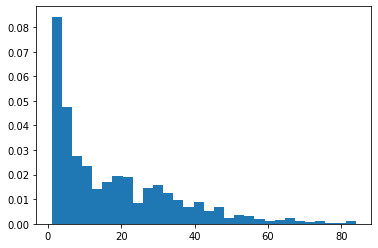

In [ ]:
# prune out players with too few plays (<minplays)
minplays=10
playerskeep=set()
numplays=[]
for ele in playerd:
  if playerd[ele]>=minplays:
    playerskeep.add(ele)
  numplays.append(playerd[ele])

plt.hist(numplays, density=True, bins=30)  #

In [ ]:
len(COYOTEd)

600

In [ ]:
frID='70'
net(torch.tensor(GetFieldStateFeatures(plID,frID,ret_vids)).float())


tensor([-0.5244], grad_fn=<AddBackward0>)

In [ ]:
x2_mat=np.array(x2_mat)
x1_mat=np.array(x1_mat)
dif=[]
for i in range(len(x2_mat)):
  dif.append(list(np.abs(x2_mat[i]-x1_mat[i])))
dif=np.array(dif)

uppercut=[]
for i in range(dif.shape[1]):
  uppercut.append(np.mean(dif[:,i])+4*np.std(dif[:,i]))

In [ ]:
np.min(np.array(uppercut)-np.abs(np.array(x1)-np.array(x2)))


-10.149189379967286

In [ ]:
COYOTEd = {} # COYOTEd[playerID][playID][frame] ==> COYOTE, ballholder_ind
detailsd = {} # detailsd[playerID][playID] ==> ballholder_ind, kicking_team_ind, playerteam, oppteam, position, jersey, teamacr, playdirection
#x1_mat=[] # toggle on for uppercut
#x2_mat=[]# toggle on for uppercut
for i in range(len(pIDs)):
    print(i,"of",len(pIDs)-1)
    plID=pIDs[i]
    teamkick=play_d[plID][4]
    homeACR=game_d[plID.split("-")[0]][4]
    awayACR=game_d[plID.split("-")[0]][5]
    if play_d[plID][15]!='NA':
        continue
    gameID=plID.split("-")[0]
    playID=plID.split("-")[1]
    playdirection=ret_vids[plID]['1']['NA'][10].strip("\"")
    playerd={}
    playerset=set(list(ret_vids[plID]['1'].keys()))
    playerset.remove('NA')
    players=list(playerset)
    playdirection=ret_vids[plID]['1']['NA'][10].strip("\"")
    for player in players:
      if player not in playerskeep:
        continue
      if player not in detailsd:
        detailsd[player]={}
      position=ret_vids[plID]['1'][player][8].strip("\"")
      jersey=ret_vids[plID]['1'][player][7]
      homeoraway=ret_vids[plID]['1'][player][9].strip("\"") # check this... is this teamacr or"home" "away"
      if homeoraway=='home':
        teamacr=homeACR
      else:
        teamacr=awayACR
      on_kicking_team=False
      if teamacr==teamkick:
        on_kicking_team=True
      detailsd[player][plID]=[on_kicking_team,teamacr,position,jersey,playdirection]# detailsd[player][plID] ==> kicking_team_ind, teamacr, position, jersey, playdirection
    for j in list(ret_vids[plID].keys()):
        frID=j
        if float(frID)<float(catchframe[plID]):
            continue
        gcpout=GetClosePlayers('NA',plID,frID,ret_vids,radius=1000)        
        bholder=gcpout['idv'][0]
        x1=GetFieldStateFeatures(plID,frID,ret_vids)
#        x2=GetFieldStateFeatures(plID,frID,ret_vids2) # toggle on for uppercut
#        x1_mat.append(x1) # toggle on for uppercut
#        x2_mat.append(x2) # toggle on for uppercut
## toggle the following OFF if calculating uppercut
        for player in players:
          if player not in playerskeep:
            continue
          x2=GetFieldStateFeatures_Adjusted(plID,frID,ret_vids,ret_vids2,player,radius=2)
          if player not in COYOTEd:
            COYOTEd[player]={}
          if plID not in COYOTEd[player]:
            COYOTEd[player][plID]={}
          on_kicking_team=detailsd[player][plID][0]
          if np.min(np.array(uppercut)-np.abs(np.array(x1)-np.array(x2)))<0 or gcpout['distv'][list(gcpout['idv']).index(player)]<3:
            COYOTEd[player][plID][frID]=[0,bholder==player]
          else:
            COYOTEd[player][plID][frID]=[Get_COYOTE(x1,x2,net,on_kicking_team),bholder==player]



In [ ]:
x1=GetFieldStateFeatures(plID,frID,ret_vids)
x2=GetFieldStateFeatures_Adjusted(plID,frID,ret_vids,ret_vids2,player,radius=2)
print(float(net(torch.tensor(x2).float())))
print(float(net(torch.tensor(x1).float())))
frID

16.689273834228516
16.58776092529297


'59'

In [ ]:
#dbfile=open("COYOTE_v4_"+YEAR+".pickle",'wb') #v3 has 0 coyote values for extreme outlier events #v4 has only off-ball events
#pickle.dump({'COYOTEd':COYOTEd,'detailsd':detailsd},dbfile)
#dbfile.close()

In [ ]:

def COYOTE_per_ret(COYOTEd,player,detailsd, retteamonly=False):
  tottot=[]
  for ele in COYOTEd[player]:
    playtot=0
    for ele2 in COYOTEd[player][ele]:
      playtot+=COYOTEd[player][ele][ele2][0]
    if not detailsd[player][ele][0] and retteamonly:
      tottot.append(playtot)
  if len(tottot)==0:
    return([0,0])
  return([sum(tottot)/len(tottot),len(tottot)])


In [ ]:
playerCOYOTEret = []
playerCOYIDs = []
for ele in COYOTEd:
  obj=COYOTE_per_ret(COYOTEd,ele,detailsd,retteamonly=True)
  if obj[1]>9:
    playerCOYIDs.append(ele)
    playerCOYOTEret.append(obj[0])
playerCOYIDs=[playerCOYIDs[x] for x in np.argsort(-np.array(playerCOYOTEret))]
playerCOYOTEret=[playerCOYOTEret[x] for x in np.argsort(-np.array(playerCOYOTEret))]


In [ ]:
playerCOYOTEret[1]

1.2834251721700032

In [ ]:
player=playerCOYIDs[-1]
plID='2020111506-2281'
frID='63'
#player='46303'#'45037'#'45008'# '45037', '46223', '46250', '46303'
print(ret_vids[plID][frID][player])
print(ret_vids2[plID][frID][player])


['109.34', '22.23', '7.49', '1.63', '0.75', '33.75', '311.03', '18', '"WR"', '"away"', '"right"']
['109.82', '21.4', '7.2', '1.64', '0.75', '193.9', '311.03', '18', '"WR"', '"away"', '"right"']


In [ ]:
pos_set=set()
for i in range(len(playerCOYIDs)):
  pos_set.add(detailsd[playerCOYIDs[i]][list(detailsd[playerCOYIDs[i]].keys())[0]][2])
pos_set

# ILB, LB, MLB, OLB, DE
# CB, DB, FS, WR, FB, RB, TE 

In [ ]:
player=playerCOYIDs[14]
plID='2020111506-2281'
frID='63'

#player=playerCOYIDs[-7] # example
player=playerCOYIDs[2] # example
plID=list(detailsd[player].keys())[0]
frID=list(COYOTEd[player][plID].keys())[8]
#detailsd[player]
players_info_d[player]
COYOTEd[player]

{'2020092013-1289': [False, 'NE', 'FB', '47', 'right'],
 '2020092013-2471': [False, 'NE', 'FB', '47', 'left'],
 '2020092013-2780': [False, 'NE', 'FB', '47', 'left'],
 '2020092013-535': [False, 'NE', 'FB', '47', 'left'],
 '2020101812-196': [False, 'NE', 'FB', '47', 'left'],
 '2020101812-432': [False, 'NE', 'FB', '47', 'left'],
 '2020101812-961': [False, 'NE', 'FB', '47', 'right'],
 '2020102510-1166': [False, 'NE', 'FB', '47', 'right'],
 '2020102510-1721': [False, 'NE', 'FB', '47', 'right'],
 '2020102510-1929': [False, 'NE', 'FB', '47', 'left'],
 '2020102510-2786': [False, 'NE', 'FB', '47', 'right'],
 '2020102510-283': [False, 'NE', 'FB', '47', 'left'],
 '2020110100-3345': [False, 'NE', 'FB', '47', 'left'],
 '2020110100-527': [False, 'NE', 'FB', '47', 'right'],
 '2020110900-1436': [False, 'NE', 'FB', '47', 'right'],
 '2020110900-2057': [False, 'NE', 'FB', '47', 'left'],
 '2020112906-237': [False, 'NE', 'FB', '47', 'right'],
 '2020112906-861': [False, 'NE', 'FB', '47', 'right'],
 '2020122

In [ ]:
retteamonly=True
tottot=[]
playIDex=[]
for ele in COYOTEd[player]:
  playtot=0
  for ele2 in COYOTEd[player][ele]:
    playtot+=COYOTEd[player][ele][ele2][0]
  if not detailsd[player][ele][0] and retteamonly:
    tottot.append(playtot)
    playIDex.append(ele)
tottot

[-1.9844160974025726,
 1.2754324674606323,
 1.3578590154647827,
 1.7535504847764969,
 5.145417630672455,
 5.170409321784973,
 -0.2973223626613617,
 1.1459951400756836,
 -1.2739472389221191,
 0.5431816577911377,
 3.349716365337372,
 1.1483335494995117,
 1.2067499160766602,
 0.33043766021728516,
 0.32659608125686646,
 2.731503129005432,
 1.540551096200943,
 0.36066433787345886,
 -0.12825989723205566,
 1.2769812047481537,
 1.6508009731769562]

In [ ]:
plID=playIDex[1]
temp=COYOTEd[player][plID]
sum=0
outele=[]
for ele in temp:
  sum+=temp[ele][0]
  outele.append(temp[ele][0])
temp
#outele
#sum





{'52': [0.07497406005859375, False],
 '53': [0.051425933837890625, False],
 '54': [-0.03381538391113281, False],
 '55': [-0.004627227783203125, False],
 '56': [0.0007266998291015625, False],
 '57': [-0.00046539306640625, False],
 '58': [0.05213165283203125, False],
 '59': [0.20093917846679688, False],
 '60': [0.11177825927734375, False],
 '61': [0.12310981750488281, False],
 '62': [0.10656356811523438, False],
 '63': [0.033431053161621094, False],
 '64': [0.061058998107910156, False],
 '65': [0.04075336456298828, False],
 '66': [-0.07416725158691406, False],
 '67': [-0.03182411193847656, False],
 '68': [-0.0036029815673828125, False],
 '69': [-0.0028734207153320312, False],
 '70': [0, False],
 '71': [0, False],
 '72': [0, False],
 '73': [0.007781982421875, False],
 '74': [-0.07791614532470703, False],
 '75': [0.066192626953125, False],
 '76': [0.04088306427001953, False],
 '77': [0.07134485244750977, False],
 '78': [0.03166484832763672, False],
 '79': [-0.004673480987548828, False],
 '

In [ ]:
plID=list(COYOTEd[player].keys())[2]
frID='59'
plID='2020122800-1541'
ret_vids[plID][frID][player]
players_info_d[player]

['6-3', '255', '1994-12-15', 'Tennessee', 'FB', 'Jakob Johnson']

In [ ]:
'48482'
players_info_d['48482']

['6-0', '237', '1998-06-25', 'Texas A&amp;M', 'MLB', 'Tyrel Dodson']

In [ ]:
#players_info_d[playerCOYIDs[-2]]
#detailsd[playerCOYIDs[-1]]
#detailsd[playerCOYIDs[0]]
#len(COYOTEd[playerCOYIDs[1]])
#COYOTEd[playerCOYIDs[-1]]



gcpout=GetClosePlayers('NA',plID,frID,ret_vids,radius=1000)        
bholder=gcpout['idv'][0]
bholder
x1=GetFieldStateFeatures(plID,frID,ret_vids)
x2=GetFieldStateFeatures_Adjusted(plID,frID,ret_vids,ret_vids2,player,radius=5)
net(torch.tensor(x2).float())
#PlotFieldPosition(ret_vids[plID][frID])
print(x2[4:6])
print(x1[4:6])

[1.7296419058362997, -6.9891586673629735]
[-4.161221045316821, 6.227707396146064]


In [ ]:
# jersey number, playerID, x,y,

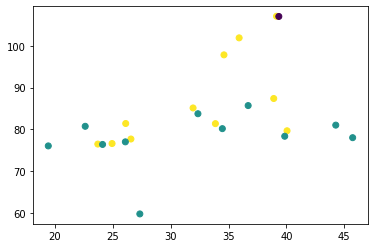

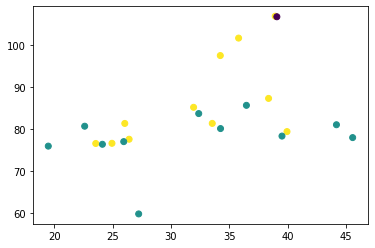

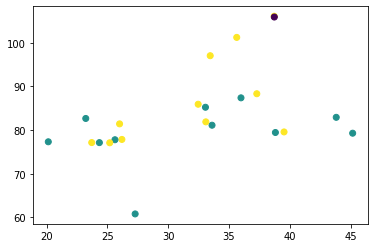

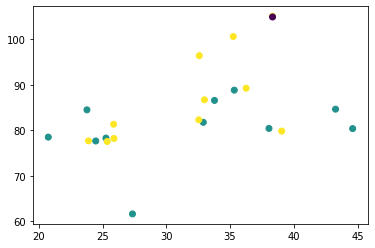

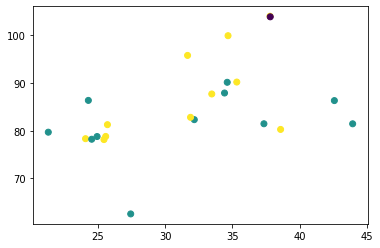

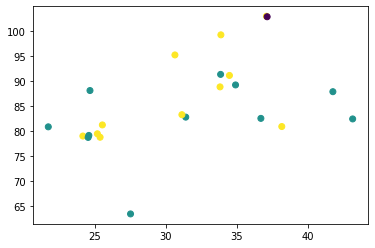

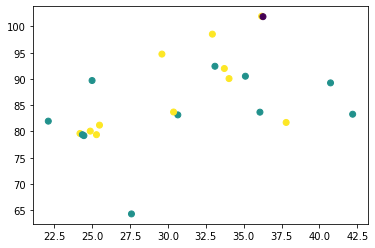

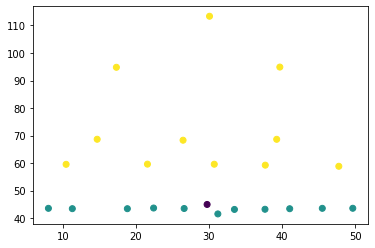

In [ ]:

PlotFieldPosition(ret_vids2[plID][frID])
PlotFieldPosition(ret_vids[plID][frID])
PlotFieldPosition(ret_vids[plID]['61'])
PlotFieldPosition(ret_vids[plID]['63'])
PlotFieldPosition(ret_vids[plID]['65'])
PlotFieldPosition(ret_vids[plID]['67'])
PlotFieldPosition(ret_vids[plID]['69'])
PlotFieldPosition(ret_vids[plID]['1'])


In [ ]:
print(x2[4:6])
print(x1[4:6])

[1.7296419058362997, -6.9891586673629735]
[-4.161221045316821, 6.227707396146064]


All of the code below runs a nice example highlighting an effective moment for a blocker. Use this in the write-up.

In [ ]:

#playerID=playerskeep[0]
output=outd[playerID]['COYOTE_perframe']

curmax=-10
idlook=1
for ii in range(len(output)):
  ele=output[ii]
  if ele[3]>curmax:
    curmax=ele[3]
    idlook=ii

#curmin=10
#idlook=1
#for ii in range(len(output)):
#  ele=output[ii]
#  if ele[3]<curmin:
#    curmin=ele[3]
#    idlook=ii

In [ ]:


for i in range(len(details)):
  if details[i][0]+"-"+details[i][1]+"-"+details[i][2]==output[idlook][0]+"-"+output[idlook][1]+"-"+output[idlook][2]:
    break


In [ ]:
if details[i][4]=="right":
  xcent=round((maxpix_x-1)*details[i][5][playerID]['x']/maxyard_x)
else:
  xcent=round((maxpix_x-1)*(1-details[i][5][playerID]['x']/maxyard_x))
ycent=round((maxpix_y-1)*(1-details[i][5][playerID]['y']/maxyard_y))
sfr1=indat['x'][i]
sfr2=indat2['x'][i]
dfr1=sfr1.to_dense()
dfr2=sfr2.to_dense()
box=FindMinClearBox2(sfr1,sfr2,xcent,ycent,yardbuf=2,overlap=True)
dfr1edit=ReplaceBox(dfr1,dfr2,box)
cCOYOTE=float(net(torch.unsqueeze(dfr1,0)))-float(net(torch.unsqueeze(dfr1edit,0)))
if details[i][5][playerID]['teamacr']=='away':
  teamacr=game_d[details[i][0]][5]
else:
  teamacr=game_d[details[i][0]][4]
if details[i][3]==teamacr: #on kicking team:
  cCOYOTE=-cCOYOTE
cCOYOTE

1.3057565689086914

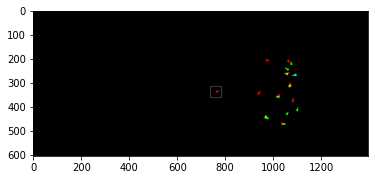

In [ ]:
maxyard_x=120;maxpix_x=1395
maxyard_y=53.3;maxpix_y=603

#playerID="NA"
sfr1=indat['x'][i]
sfr2=indat2['x'][i]
curloc=ret_vids[output[idlook][0]+"-"+output[idlook][1]][output[idlook][2]][playerID]
curx=round((maxpix_x-1)*(1-float(curloc[0])/maxyard_x))
cury=round((maxpix_y-1)*(1-float(curloc[1])/maxyard_y))
#box=FindMinClearBox2(sfr1,sfr2,curx,cury,2)
temp0=AddWhiteBox(sfr1,box[0],box[1],box[2],box[3])
temp=np.moveaxis(torch.Tensor.numpy(temp0),0,-1)
plt.imshow(temp)


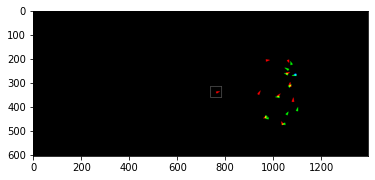

In [ ]:
temp0=AddWhiteBox(dfr1edit,box[0],box[1],box[2],box[3],sparse=False)
temp=np.moveaxis(torch.Tensor.numpy(temp0),0,-1)
plt.imshow(temp)

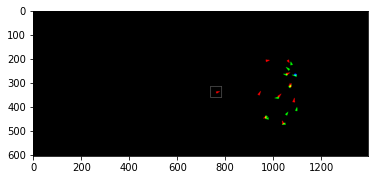

In [ ]:
temp0=AddWhiteBox(sfr2,box[0],box[1],box[2],box[3])
temp=np.moveaxis(torch.Tensor.numpy(temp0),0,-1)
plt.imshow(temp)

As can be seen in the above two plots, when the RB (the green triangle in the white box) has more space between him and the opponent he aims to block, this decreases the expected return by 3 yards. The average player would have this gap, but this RB closed the gap completely in the .1 seconds, much more than the average player would. This does not allow the opponent to turn and head off the kick returner coming in their direciton.

In [ ]:
class Net2(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(42, 50)
        self.fc2 = nn.Linear(50,25)
        self.fc3 = nn.Linear(25,10)
        self.fc4 = nn.Linear(10, 5)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)#.squeeze()
        return x
    
    

net2 = Net2()
modelpath=data_dir+"/nextposFFNN_take2_19.pt"
net2.load_state_dict(torch.load(modelpath))

<All keys matched successfully>

In [ ]:
playerID=playerCOYIDs[-1]
plID='2020111506-2281'
frID='63'


In [ ]:
frID='62'


playerIDs=list(ret_vids[plID][frID].keys())
teamkick=play_d[plID][4]
homeACR=game_d[plID.split("-")[0]][4]
awayACR=game_d[plID.split("-")[0]][5]
if teamkick==homeACR:
  homekick=True
else:
  homekick=False
frIDs=list(ret_vids[plID].keys())
j=int(frID)-1
for k in range(len(playerIDs)):
  playerID=playerIDs[k]
  if playerID=="NA":
    continue
  # get outcome vector: deltax,deltay, a, xspd, yspd
  cx=float(ret_vids[plID][frID][playerID][0])
  cy=float(ret_vids[plID][frID][playerID][1])
  cs=float(ret_vids[plID][frID][playerID][2])
  ca=float(ret_vids[plID][frID][playerID][3])
  cdis=float(ret_vids[plID][frID][playerID][4])
  co=float(ret_vids[plID][frID][playerID][5])
  nx=float(ret_vids[plID][frIDs[j+1]][playerID][0])
  ny=float(ret_vids[plID][frIDs[j+1]][playerID][1])
  ns=float(ret_vids[plID][frIDs[j+1]][playerID][2])
  na=float(ret_vids[plID][frIDs[j+1]][playerID][3])
  ndis=float(ret_vids[plID][frIDs[j+1]][playerID][4])
  no=float(ret_vids[plID][frIDs[j+1]][playerID][5])
  temp=os2xyspeed(no,ns)
  nxspd=temp[0]
  nyspd=temp[1]
  temp=os2xyspeed(co,cs)
  cxspd=temp[0]
  cyspd=temp[1]
  cury=[nx-cx,ny-cy,na,nxspd,nyspd]
  ### get 3 closest players
  gcpout=GetClosePlayers(playerID,plID,frID,ret_vids,radius=250)
  # get predictor vector: a, xspd, yspd, dis----plus--- top 3 closest reldis, relx, rely, a, xspd, yspd
  curx=[ca,cxspd,cyspd,cdis]
  for l in range(5):
    ID2=gcpout['idv'][l]
    cx2=float(ret_vids[plID][frID][ID2][0])
    cy2=float(ret_vids[plID][frID][ID2][1])
    cs2=float(ret_vids[plID][frID][ID2][2])
    ca2=float(ret_vids[plID][frID][ID2][3])
    cdis2=float(ret_vids[plID][frID][ID2][4])
    co2=float(ret_vids[plID][frID][ID2][5])
    temp=os2xyspeed(co2,cs2)
    cxspd2=temp[0]
    cyspd2=temp[1]
    if ret_vids[plID][frID][ID2][9]==ret_vids[plID][frID][playerID][9]:
      sameteam=1
    else:
      sameteam=0
    curx+=[np.sqrt((cx2-cx)**2+(cy2-cy)**2),cx2-cx,cy2-cy,ca2,cxspd2,cyspd2,sameteam]
  # also add the relx and rely of the ball to the player
  cx2=float(ret_vids[plID][frID]['NA'][0])
  cy2=float(ret_vids[plID][frID]['NA'][1])
  cretind=0
  if (homekick and ret_vids[plID][frID][playerID][9].strip("\"")=="home") or ((not homekick) and ret_vids[plID][frID][playerID][9].strip("\"")=="away"):
    cretind=1
  curx+=[cx2,cy2,cretind]

#x,y,s,a,dis,o,dir,jersey,pos,team,playdirectino

In [ ]:
ret_vids[plID][frID][playerID]

['109.34',
 '22.23',
 '7.49',
 '1.63',
 '0.75',
 '33.75',
 '311.03',
 '18',
 '"WR"',
 '"away"',
 '"right"']

In [ ]:
o=ret_vids[plID][frID][playerID][5]
s=ret_vids[plID][frID][playerID][2]
print(net2(torch.tensor(curx).float()))
temp=os2xyspeed(float(o),float(s))
nxspd=temp[0]
nyspd=temp[1]
print(nxspd,nyspd)

tensor([ 0.2968,  0.3375,  1.1248, -3.5689,  4.6178], grad_fn=<AddBackward0>)
4.161221045316821 6.227707396146064
